In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)
dataset.class_names

Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)


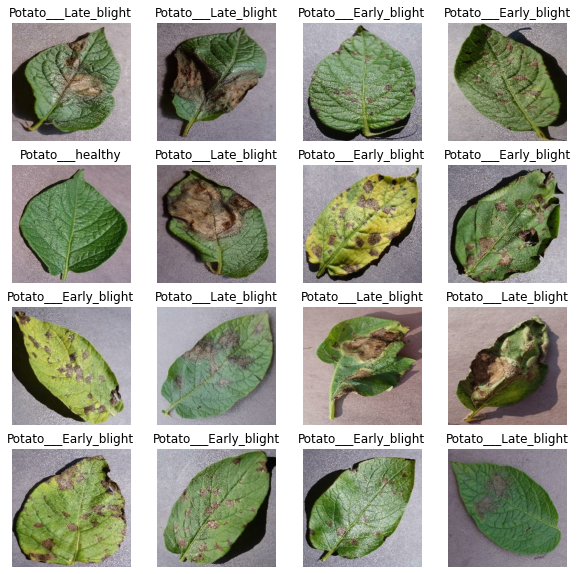

In [4]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels_batch[i]])
        plt.axis("off")

In [5]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [7]:
len(train_ds), len(test_ds), len(val_ds)

(54, 8, 6)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu",  input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

In [12]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS
)

Epoch 1/30
54/54 [==============================] - 39s 402ms/step - loss: 0.9087 - accuracy: 0.4912 - val_loss: 0.9116 - val_accuracy: 0.4583
Epoch 2/30
54/54 [==============================] - 8s 156ms/step - loss: 0.7720 - accuracy: 0.6502 - val_loss: 0.6576 - val_accuracy: 0.7865
Epoch 3/30
54/54 [==============================] - 6s 118ms/step - loss: 0.5118 - accuracy: 0.8005 - val_loss: 0.5521 - val_accuracy: 0.7865
Epoch 4/30
54/54 [==============================] - 6s 118ms/step - loss: 0.4159 - accuracy: 0.8251 - val_loss: 0.7094 - val_accuracy: 0.6771
Epoch 5/30
54/54 [==============================] - 7s 121ms/step - loss: 0.4381 - accuracy: 0.8245 - val_loss: 0.6257 - val_accuracy: 0.7083
Epoch 6/30
54/54 [==============================] - 7s 121ms/step - loss: 0.3114 - accuracy: 0.8709 - val_loss: 0.1936 - val_accuracy: 0.9375
Epoch 7/30
54/54 [==============================] - 7s 124ms/step - loss: 0.2863 - accuracy: 0.8903 - val_loss: 0.2418 - val_accuracy: 0.9219
Epoch

In [15]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 73ms/step - loss: 0.0897 - accuracy: 0.9648


In [16]:
scores

[0.08972930908203125, 0.96484375]

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

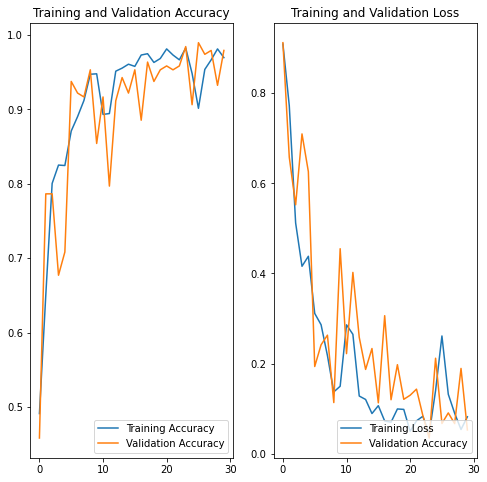

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')


plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Loss")

plt.show()

Predictions

Actual Label:  Potato___Early_blight
Predicted label:  Potato___Early_blight


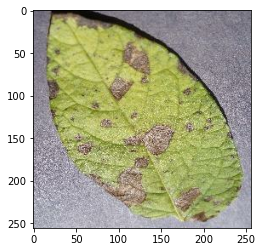

In [19]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    print("Predictions\n")
    plt.imshow(first_image)
        
    print('Actual Label: ',dataset.class_names[labels_batch[0].numpy()])
    batch_predction=model.predict(image_batch)
    print('Predicted label: ',dataset.class_names[np.argmax(batch_predction[0])])


In [20]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0)

    predictions=model.predict(img_array)
    predicted_class=dataset.class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

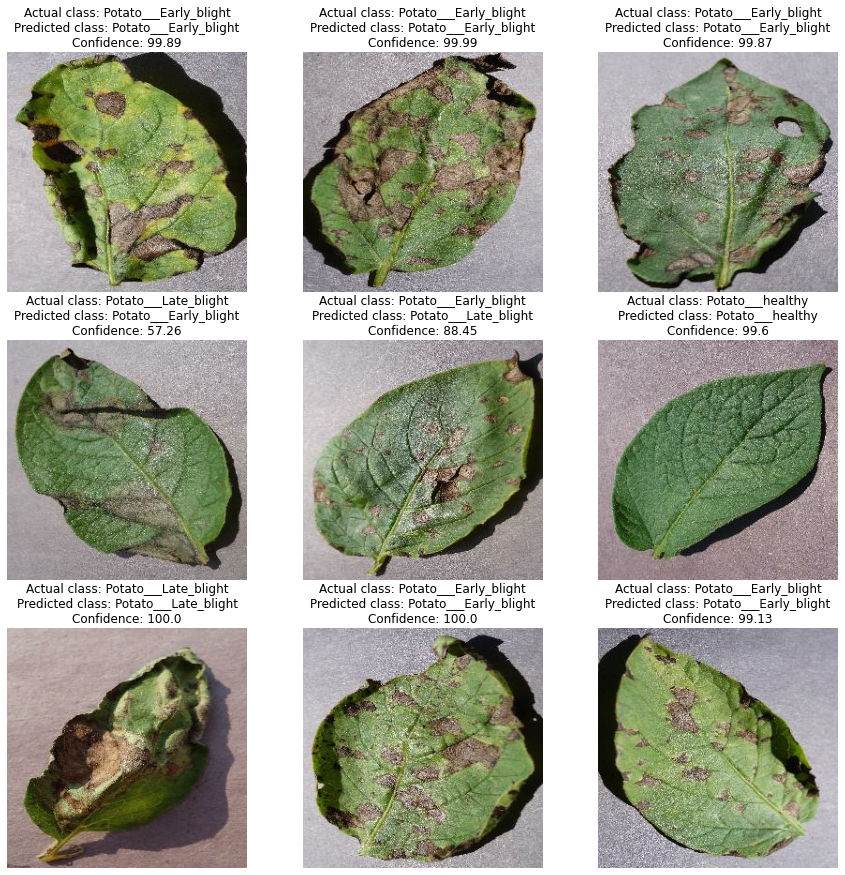

In [21]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])

        actual_class=dataset.class_names[labels[i]]
        plt.title(f"Actual class: {actual_class}\nPredicted class: {predicted_class}\nConfidence: {confidence}")
        plt.axis("off")

In [37]:
import os
path = "../models"
dir=os.listdir(path)
if len(dir)==0:
    model_version=1
    model.save(f"../models/{model_version}")
    model_version+=1
else:
    model.save(f"../models/{model_version}")
    model_version+=1



INFO:tensorflow:Assets written to: ../models/3\assets
